## Answers to DSInterviewChallengeV_2_4
#### by *Bakhtiyar Ruzybayev, PhD*
#### Email: bakhtiyaruz@gmail.com
#### **07/23/2016**
---

# Part 1 SQL

#### Question
* For each of the cities 'Qarth' and 'Meereen', calculate 90th percentile difference between Actual and Predicted ETA for all completed trips within the last 30 days.

#### Answer 
(assuming PostgreSQL 9.5)
```SQL
select city_name, percentile_disc(0.9) within group (order by time_diff) as time_diff_90
from (
      select table1.city_id, table2.city_name,
             (table1.actual_eta-table1.predicted_eta) as time_diff
      from trips as table1
      join cities as table2
      on table1.city_id=table2.city_id
      where table1.request_at > NOW() - INTERVAL '30 days'
      and table1.status = 'completed'
      and table2.city_name in ('Qarth','Meereen')
     )
group by city_name;
```

#### Question
* A signup is defined as an event labeled ‘sign_up_success’ within the events table. For each city (‘Qarth’ and ‘Meereen’) and each day of the week, determine the percentage of signups in the first week of 2016 that resulted in completed a trip within 168 hours of the sign up date.

#### Answer
```SQL
select table2.city_name, table1.day_of_week, (100*sum(table1.completed_trip)/count(*)) as sct_percentage
from (
      select a.city_id, extract(DOW from a._ts) as day_of_week,
             CASE WHEN DATEDIFF(hour, a._ts, b.request_at)<=168 and b.status = 'completed'
                  THEN 1
                  ELSE 0
             END as completed_trip
      from events as a
      join trips as b
      on a.city_id = b.city_id
      where a.event_name = 'sign_up_success'
      and a._ts between '2016-01-01 00:00:00'::timestamp and '2016-01-08 00:00:00'::timestamp
     ) as table1
join cities as table2
on table1.city_id=table2.city_id
and table2.city_name in ('Qarth','Meereen')
group  by  1, 2;
```

# Part 2 Experiment and metrics design

#### Success metrics for new Uber Partner App

* Primary success metric should be active user count. Where active user is defined as any partner that frequently uses advanced features of the new app. For example: Use of heat map, action on the Uber feed, use of earnings and ratings tabs. Success could be defined as higher percentage of active users compared to the old app. Since the goal of the new app is to improve experience for the drivers, the use of these new features will demonstrate that drivers indeed value them.
* Secondary metrics can be:  
    1.	App rating in the app store (To se if the new app is perceived well)
    2.	Partner’s average earnings per trip/day/week (To measure if the new app is helping drivers be more efficient)
    3.	Partner’s rating (To see if the new app helping drivers improve their ratings)

#### Testing
1.	For regions where both old and new apps are being used:
    1.	Calculate fractions of active users for both apps
    2.	Calculate average earnings per trip/day/week for both apps, across all partners
    3.	Calculate average ratings of partners for both apps, across all partners
2.	For people that switched to new app:
    1.	Calculate how many were ‘active’ before and after (Testing whether the new app is more engaging)
    2.	Calculate if the switch to a new app caused a statistically significant increase or decrease on average earning per trip/day/week.
    3.	Calculate if the switch to a new app caused a statistically significant increase or decrease on the rating of the partner.
3.	Compare ratings for the new and old apps in the app store for comparable periods  

First test, comparing app performance across all partners can yield statistically significant results faster, since we will be looking at all partners and average across all. 
Second test will be more precise measurement but will need longer time since calculation will be made on individual partner level.
Third test is straightforward and can yield results relatively fast.
Based on the result(s) of the first test (and probably third), we can judge on the duration or implementation of the second test.

#### Recommendation
Based on the defined metrics (% of active users, app rating, earnings per trip/day/week, rating of the partner):	
* If the new app performs better in at least one metric, especially primary, while other metrics are unaffected, we would recommend launch of the new app.
* If the new app is performing worse in at least one metric, especially primary, while other metrics are unaffected, we would recommend to roll it back.
* In all other cases we would recommend further studies if feasible.

# Part 3 Data analysis

In [1]:
import pandas as pd
import numpy as np

Loading data. Input file name was changed from `ds_challenge_v2_1_data (1).csv` to `ds_challenge_v2_1_data.csv`

In [2]:
data=pd.read_csv('/Users/dkh320/Desktop/Family/Bakhtiyar/Applications/U_app_exam/ds_challenge_v2_1_data.csv')

Checking sample data

In [3]:
data.loc[:10,]

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN
5,6,Strark,android web,Referral,1/18/16,1/18/16,1/22/16,Cadillac,DTS,2006.0,NaN
6,7,Strark,ios web,Paid,1/14/16,1/16/16,1/21/16,Toyota,Prius V,2014.0,1/23/16
7,8,Strark,ios web,Referral,1/26/16,2/5/16,NaN,NaN,NaN,NaN,NaN
8,9,Strark,NaN,Referral,1/5/16,NaN,NaN,NaN,NaN,NaN,NaN
9,10,Berton,ios web,Paid,1/25/16,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Analysis and Data Cleaning

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
from collections import Counter

channels = Counter(data['signup_channel'])
channels

Counter({'Organic': 13427, 'Paid': 23938, 'Referral': 17316})

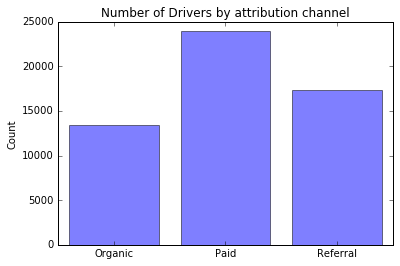

In [29]:
objects = ('Organic','Paid', 'Referral')
y_pos = np.arange(len(objects))
attribution = [channels['Organic'],channels['Paid'],channels['Referral']] 
plt.bar(y_pos, attribution, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Number of Drivers by attribution channel')

In [30]:
os = Counter(data['signup_os'])
os

Counter({nan: 6857,
         'android web': 14944,
         'ios web': 16632,
         'mac': 5824,
         'other': 3648,
         'windows': 6776})

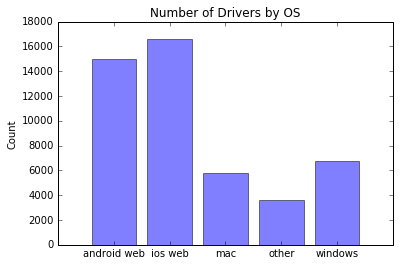

In [32]:
objects = ('android web', 'ios web', 'mac', 'other', 'windows')
y_pos = np.arange(len(objects))
attribution = [os['android web'],os['ios web'],os['mac'],os['other'],os['windows']] 
plt.bar(y_pos, attribution, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Number of Drivers by OS')

1. Converting categorical variables into numercial
2. Creating new variables that represent completion of certain actions (ex: `bgc`: Back ground check consent)
3. Replace NaNs with 0 or "Unknown[variable]" where possible. Where variable corresponds to the column name
4. Creating target variable `has_driven` that has value 1 or 0 (True/False) that we will try to predict

Creating new variables called `bgc` (back ground check), `vehicle_added` that will simply state wether the event happened or not (1 or 0). The assumptions is that if the date exists (not NaN), the event happened. Aslo converting `vehicle_year` to integer and assigning 0 where NaN. 

In [33]:
bgc = [pd.notnull(i)*1 for i in data.bgc_date]
vehicle_added = [pd.notnull(i)*1 for i in data.vehicle_added_date]
vehicle_year = [int(i) for i in data.vehicle_year.fillna(0)]

Putting new variable into a temporary data frame.

In [34]:
subdata = pd.DataFrame({'bgc':bgc,'vehicle_added':vehicle_added, 'vehicle_year':vehicle_year})

Creating target variable `has_driven` that we will try to predict.

In [35]:
has_driven = [pd.notnull(i)*1 for i in data.first_completed_date]

Checking the number of drivers after each stage

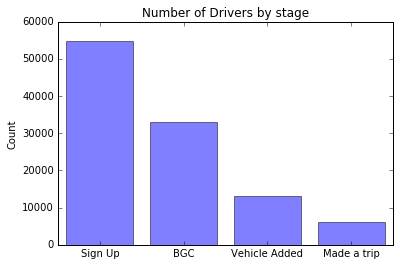

In [40]:
objects = ('Sign Up', 'BGC', 'Vehicle Added', 'Made a trip')
y_pos = np.arange(len(objects))
attribution = [len(data['signup_date']), sum(bgc), sum(vehicle_added), sum(has_driven)] 
plt.bar(y_pos, attribution, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Number of Drivers by stage')

Converting categorical variables to numeric. That is the value of each category becomes a new variable with 1 or 0.
NaN values will become `Unknown[Variable]` where `Variable` corresponds to the original column name.

In [41]:
cities = pd.get_dummies(data.city_name.fillna('UnknownCity'))
os = pd.get_dummies(data.signup_os.fillna('UnknownOS'))
channel = pd.get_dummies(data.signup_channel.fillna('UnknownChannel'))
vehicle_make = pd.get_dummies(data.vehicle_make.fillna('UnknownMake'))
vehicle_model = pd.get_dummies(data.vehicle_model.fillna('UnknownModel'))

Combining new variables into new, single, "cleaned" data frame: `clean_data`

In [42]:
clean_data=pd.concat([cities,os,channel,vehicle_make,vehicle_model, subdata],axis=1)

Checking sample of the "clean" data.

In [43]:
clean_data.loc[:3]

,Berton,Strark,Wrouver,UnknownOS,android web,ios web,mac,other,windows,Organic,...,i3,iA,iM,tC,xA,xB,xD,bgc,vehicle_added,vehicle_year
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2016


Cheking the row count for original and cleaned data.

In [44]:
print clean_data.shape, data.shape

(54681, 431) (54681, 11)


So we have same row count but `clean_data` has more columns (variables) than original `data`, as expected.

## Question 1

Assuming drivers that did not complete their first trips have NaN value for their 'first_completed_date' column, 
the number of drivers that did drive: 

In [45]:
sum(has_driven)

6137

Checking whether all original 54'681 drivers were unique:

In [46]:
len((data.id.unique()))

54681

The question was 'What fraction of the driver
signups took a first trip?'

The answer is the ratio of number of drivers in `has_driven` list to the number of unique drivers in the original `data` table.

In [47]:
print 'Answer = ', round(sum(has_driven)/float(len(data['id'])),2) 

Answer =  0.11


Only 11% of the drivers that signed up, completed their first trips in January 2015.

## Question 2 (Modeling)


Splitting data set into training and test. 67% to training set and 33% to test set. Will use pythons **sklearn** libraries.

In [48]:
from sklearn.cross_validation import train_test_split

In [49]:
has_driven = pd.Series(has_driven)
X_train, X_test, Y_train, Y_test = train_test_split(clean_data, has_driven, test_size=0.33,random_state=43)

Checking whether both data sets (train and test) have same ratio of drivers that have driven. 

In [50]:
print 'Train data set ratio: ', sum(Y_train)/float(X_train['bgc'].count())
print 'Test data set ratio:  ', sum(Y_test)/float(X_test['bgc'].count())

Train data set ratio:  0.113194671907
Test data set ratio:   0.110279855916


#### Setting up model
Will use logistic regression as a starting model as it is relatively easy and gives results faster.

In [51]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()

In [52]:
logistic.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
Y_predict = logistic.predict(X_test)

Measuring: Accuracy, Precision and Recall of the model.

In [54]:
from sklearn.metrics import accuracy_score, precision_score,recall_score

In [55]:
print 'Accuracy: ', round(accuracy_score(Y_test,Y_predict),2)
print 'Precission: ', round(precision_score(Y_test,Y_predict),2)
print 'Recall: ', round(recall_score(Y_test,Y_predict),2)

Accuracy:  0.89
Precission:  0.52
Recall:  0.42


Looking for the coefficients of the model to identify 'high impact' variables.

In [56]:
variable = []
coefficient = []

for i in range(len(logistic.coef_[0])):
    variable.append(clean_data.columns[i])
    coefficient.append(round(logistic.coef_[0][i],3))

In [57]:
Variable_strength = pd.DataFrame({'Variable':variable, 'Coeff':coefficient})

In [58]:
print 'Top 10 positive'
print Variable_strength.sort_values(by='Coeff', ascending=False).iloc[0:10]
print '\nTop 10 negative'
print Variable_strength.sort_values(by='Coeff', ascending=True).iloc[0:10]

Top 10 positive
     Coeff      Variable
428  3.939           bgc
195  1.155     GLA-Class
388  1.138           VUE
134  1.085     Commander
259  1.004           MPV
161  0.988      Endeavor
103  0.944  C-Max Hybrid
201  0.940            GX
335  0.937           SRX
181  0.927          Flex

Top 10 negative
     Coeff      Variable
55  -1.606   UnknownMake
384 -1.606  UnknownModel
3   -1.281     UnknownOS
10  -1.152          Paid
92  -1.147          Aveo
197 -1.104     GLK-Class
145 -1.082           DTS
424 -1.042            tC
9   -1.036       Organic
199 -1.014     GS Hybrid


* `bgc` variable, that is background check consent event seems to have the highest impact.
* Next strongest variables in this model are vehicle models (or lack thereof).

#### Dummy models for comparison
To compare performance of the model we create two simple models that either predict that all sign ups will drive or all sign ups will not drive.

In [59]:
Y_p_alltrue = [1 for i in range(len(Y_predict))]
Y_p_allfalse = [0 for i in range(len(Y_predict))]

In [60]:
print 'Performance of "All drive" dummy model'
print 'Accuracy: ', round(accuracy_score(Y_test,Y_p_alltrue),2)
print 'Precision: ', round(precision_score(Y_test,Y_p_alltrue),2)
print 'Recall: ', round(recall_score(Y_test,Y_p_alltrue),2)

Performance of "All drive" dummy model
Accuracy:  0.11
Precision:  0.11
Recall:  1.0


In [61]:
print 'Performance of "Nobody drives" dummy model'
print 'Accuracy: ', round(accuracy_score(Y_test,Y_p_allfalse),2)
print 'Precision: ', round(precision_score(Y_test,Y_p_allfalse),2)
print 'Recall: ', round(recall_score(Y_test,Y_p_allfalse),2)

Performance of "Nobody drives" dummy model
Accuracy:  0.89
Precision:  0.0
Recall:  0.0


/Users/dkh320/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Another try with fewer features

Will remove vehicle model from the data and rerun the logistic regression.

In [62]:
r_clean_data=pd.concat([cities,os,channel,vehicle_make, subdata],axis=1)

In [63]:
r_clean_data.shape

(54681, 62)

The new data has only 62 features

In [64]:
X_train_r, X_test_r, Y_train_r, Y_test_r = train_test_split(r_clean_data, has_driven, test_size=0.33,random_state=43)

In [65]:
logistic_r = linear_model.LogisticRegression()
logistic.fit(X_train_r,Y_train_r)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
Y_predict_r = logistic.predict(X_test_r)

In [67]:
print 'Accuracy: ', round(accuracy_score(Y_test_r,Y_predict_r),2)
print 'Precission: ', round(precision_score(Y_test_r,Y_predict_r),2)
print 'Recall: ', round(recall_score(Y_test_r,Y_predict_r),2)

Accuracy:  0.89
Precission:  0.52
Recall:  0.38


Eliminating vehicle model didnt have any impact on Accuracy and Precission but reduced Recall from 42% to 38%.
Indicating that vehicle model has some distinguishing power.

#### K-Means
For an alternative method we will try K-Means clustering with a renage of nearest neighbors.

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
knn_model3 = KNeighborsClassifier(n_neighbors=3)
knn_model5 = KNeighborsClassifier(n_neighbors=5)
knn_model10 = KNeighborsClassifier(n_neighbors=10)
knn_model20 = KNeighborsClassifier(n_neighbors=20)
knn_model50 = KNeighborsClassifier(n_neighbors=50)
knn_model100 = KNeighborsClassifier(n_neighbors=100)

In [51]:
knn_model3.fit(X_train,Y_train)
knn_model5.fit(X_train,Y_train)
knn_model10.fit(X_train,Y_train)
knn_model20.fit(X_train,Y_train)
knn_model50.fit(X_train,Y_train)
knn_model100.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

In [53]:
Y_pred3 = knn_model3.predict(X_test)
Y_pred5 = knn_model5.predict(X_test)
Y_pred10 = knn_model10.predict(X_test)
Y_pred20 = knn_model20.predict(X_test)
Y_pred50 = knn_model50.predict(X_test)
Y_pred100 = knn_model100.predict(X_test)

In [54]:
print "k=3:", round(accuracy_score(Y_test,Y_pred3),4)
print "k=5:", round(accuracy_score(Y_test,Y_pred5),4)
print "k=10:", round(accuracy_score(Y_test,Y_pred10),4)
print "k=20:", round(accuracy_score(Y_test,Y_pred20),4)
print "k=50:", round(accuracy_score(Y_test,Y_pred50),4)
print "k=100:", round(accuracy_score(Y_test,Y_pred100),4)

k=3: 0.8832
k=5: 0.8861
k=10: 0.8885
k=20: 0.8892
k=50: 0.8913
k=100: 0.8913


In [55]:
print "k=3:", round(precision_score(Y_test,Y_pred3),4)
print "k=5:", round(precision_score(Y_test,Y_pred5),4)
print "k=10:", round(precision_score(Y_test,Y_pred10),4)
print "k=20:", round(precision_score(Y_test,Y_pred20),4)
print "k=50:", round(precision_score(Y_test,Y_pred50),4)
print "k=100:", round(precision_score(Y_test,Y_pred100),4)

k=3: 0.4684
k=5: 0.4819
k=10: 0.4918
k=20: 0.4968
k=50: 0.51
k=100: 0.5103


In [56]:
print "k=3:", round(recall_score(Y_test,Y_pred3),4)
print "k=5:", round(recall_score(Y_test,Y_pred5),4)
print "k=10:", round(recall_score(Y_test,Y_pred10),4)
print "k=20:", round(recall_score(Y_test,Y_pred20),4)
print "k=50:", round(recall_score(Y_test,Y_pred50),4)
print "k=100:", round(recall_score(Y_test,Y_pred100),4)

k=3: 0.4402
k=5: 0.4337
k=10: 0.3296
k=20: 0.3523
k=50: 0.3603
k=100: 0.3598


#### Model discussions
K-Means algorithm does not show any significant improvements over Logistic Regression. 
Among all the models we tried, Logistic Regression using entire clean_data with all the features showed the best performance based on the combination of: Accuracy, Precission and Recall. As with any modeling, we need to pay attention as not to overfit with training data, idependent of the algorithm we use. For possible improvements
we might look for:
1. New features (For example: time between certain actions. Sign up to BGC, bgc to add vehicle, etc)
2. Feature extraction
3. Functional forms of features
4. Feature interactions
5. Sensible combinations of features
6. Regularization
7. Other methods/algorithms

## Question 3 (Recomendation)

Based on the models we built from the provided data, the insight we found is that "Back ground check consent" has a significant impact on telling whether the driver will make a trip or not. Possible leverage:
* Give drivers that passed BGC stage, but have not made a trip, a nudge (incentive or friendly reminder)
* Make back ground check consent request less intimidating and/or friendly